In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import statsmodels.api as sm
import seaborn as sns
from pandas_datareader import data as pd_data
from sklearn.metrics import explained_variance_score
import laplacejumps as lj

/home/sangrey/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
np.set_printoptions(precision=6)
pd.options.display.precision = 6
mpl.pyplot.style.use('seaborn-talk')

In [3]:
volatility_store = pd.HDFStore('../results/spy_volatility_estimates_2003-2014.hdf')
# volatility_store = pd.HDFStore('../results/xlr_volatility_estimates_2005-2014.tmp.hdf')
discrete_vol = volatility_store['discrete_trunc_vol']
daily_rtn = volatility_store['daily_rtn']
discrete_vol['quad'] = discrete_vol['jumps'] + discrete_vol['diffusion']
treasury_yield = pd_data.get_data_fred('DGS10', start='1950', end='2018').apply(
    lambda x: np.log(x/(100 * 365) + 1)).rename(columns={'DGS10':'log_yield'})

In [4]:
vix = pd_data.get_data_fred('VIXCLS', start='1950', end='2018').rename(columns={'VIXCLS':'vix'})
discrete_vol['vix'] = (vix / 100)**2 / (30 * 12)
log_vol = discrete_vol.apply(np.log).dropna()

In [5]:
vix_diff = pd.DataFrame(discrete_vol['vix']- discrete_vol['quad']).rename(columns={0:'vix_diff'})

In [6]:
discrete_vol.apply(np.sqrt).describe()

diffusion        jumps         quad          vix
count  3021.000000  3021.000000  3021.000000  3021.000000
mean      0.007169     0.009140     0.011696     0.010446
std       0.005923     0.005924     0.008265     0.004934
min       0.001892     0.002121     0.003284     0.005212
25%       0.004182     0.005620     0.007119     0.007199
50%       0.005492     0.007454     0.009338     0.009007
75%       0.007970     0.010740     0.013365     0.011927
max       0.098621     0.079322     0.126562     0.042617

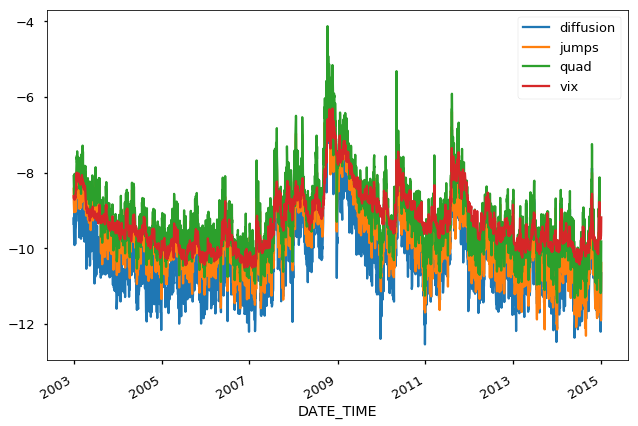

In [7]:
log_vol.plot()

## Analyze the Return volatility Relationship

In [8]:
pd.concat([discrete_vol,daily_rtn], axis=1).dropna().resample('M').sum().head()

diffusion     jumps      quad       vix  daily_rtn
DATE_TIME                                                     
2003-01-31   0.002524  0.003960  0.006484  0.004445  -0.034499
2003-02-28   0.002244  0.004622  0.006866  0.005488  -0.014315
2003-03-31   0.002772  0.005060  0.007832  0.005491   0.004281
2003-04-30   0.001711  0.003663  0.005374  0.003416   0.077632
2003-05-31   0.001232  0.002886  0.004118  0.002394   0.053941

In [9]:
def test_all_but_intercept_irrelevant(model):
    
    return model.wald_test([0] + [1]*(model.params.size-1))

In [10]:
vix_data = pd.concat([discrete_vol,daily_rtn], axis=1).dropna().resample('D').sum().dropna()
vix_model = sm.WLS.from_formula("""daily_rtn ~ vix.shift(1).apply(np.log)""", 
                                weights=vix_data['quad'].shift(1)**(-1),data=vix_data).fit()
vix_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Weigthed least squares
======================================================================
Model:                WLS              Adj. R-squared:     0.001      
Dependent Variable:   daily_rtn        AIC:                -19902.5204
Date:                 2017-11-15 14:45 BIC:                -19890.4943
No. Observations:     3020             Log-Likelihood:     9953.3     
Df Model:             1                F-statistic:        5.233      
Df Residuals:         3018             Prob (F-statistic): 0.0222     
R-squared:            0.002            Scale:              0.78619    
----------------------------------------------------------------------
                           Coef.  Std.Err.   t    P>|t|  [0.025 0.975]
----------------------------------------------------------------------
Intercept                  0.0062   0.0026 2.3721 0.0178 0.0011 0.0113
vix.shift(1).apply(np.log) 0.0006   0.0003 2.2876 0.0222 0.0001 0.0011
----------------------------------------------------------------------
Omnibus:               184.219        Durbin-Watson:           2.087  
Prob(Omnibus):         0.000          Jarque-Bera (JB):        346.459
Skew:                  -0.441         Prob(JB):                0.000  
Kurtosis:              4.405          Condition No.:           191    
======================================================================

"""

In [11]:
test_all_but_intercept_irrelevant(vix_model)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[ 5.233188]]), p=0.02222876385435323, df_denom=3018, df_num=1>

In [12]:
rv_data = pd.concat([discrete_vol,daily_rtn], axis=1).dropna().resample('D').sum().dropna()
rv_model = sm.WLS.from_formula("""daily_rtn ~ quad.shift(1).apply(np.log)""", 
                               weights=rv_data['vix']**(-1),data=rv_data).fit(cov_type='HAC',
                                                                              cov_kwds={'maxlags':12})
rv_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Weigthed least squares
=======================================================================
Model:               WLS               Adj. R-squared:      0.004      
Dependent Variable:  daily_rtn         AIC:                 -19991.8213
Date:                2017-11-15 14:45  BIC:                 -19979.7953
No. Observations:    3020              Log-Likelihood:      9997.9     
Df Model:            1                 F-statistic:         17.17      
Df Residuals:        3018              Prob (F-statistic):  3.52e-05   
R-squared:           0.004             Scale:               0.84001    
-----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------
Intercept                   0.0076   0.0017 4.6260 0.0000 0.0044 0.0109
quad.shift(1).apply(np.log) 0.0007   0.0002 4.1432 0.0000 0.0004 0.0010
-----------------------------------------------------------------------
Omnibus:                12.824         Durbin-Watson:            2.115 
Prob(Omnibus):          0.002          Jarque-Bera (JB):         16.199
Skew:                   -0.053         Prob(JB):                 0.000 
Kurtosis:               3.343          Condition No.:            128   
=======================================================================

"""

In [13]:
test_all_but_intercept_irrelevant(rv_model)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test: statistic=[[ 17.166402]], p-value=3.424397094336128e-05>

In [14]:
vix_diff_data = pd.concat([discrete_vol, vix_diff, daily_rtn], axis=1).resample('M').sum().rename(
    columns={0:'vix_diff'}).dropna()
vix_diff_model = sm.WLS.from_formula("""daily_rtn ~ vix_diff.shift(1)""",
                                     weights=vix_diff_data['vix']**(-1),data=vix_diff_data).fit()
vix_diff_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Weigthed least squares
==================================================================
Model:              WLS              Adj. R-squared:     0.004    
Dependent Variable: daily_rtn        AIC:                -584.3025
Date:               2017-11-15 14:45 BIC:                -578.3769
No. Observations:   143              Log-Likelihood:     294.15   
Df Model:           1                F-statistic:        1.558    
Df Residuals:       141              Prob (F-statistic): 0.214    
R-squared:          0.011            Scale:              0.49335  
------------------------------------------------------------------
                      Coef.  Std.Err.   t    P>|t|   [0.025 0.975]
------------------------------------------------------------------
Intercept             0.0118   0.0024 4.8855 0.0000  0.0070 0.0165
vix_diff.shift(1)     1.5038   1.2049 1.2480 0.2141 -0.8783 3.8859
------------------------------------------------------------------
Omnibus:              6.871         Durbin-Watson:           2.078
Prob(Omnibus):        0.032         Jarque-Bera (JB):        4.235
Skew:                 -0.247        Prob(JB):                0.120
Kurtosis:             2.316         Condition No.:           516  
==================================================================

"""

In [15]:
test_all_but_intercept_irrelevant(vix_diff_model)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[ 1.557609]]), p=0.21408414712746932, df_denom=141, df_num=1>

In [16]:
jump_prop_data.head()

NameError: name 'jump_prop_data' is not defined

In [ ]:
jump_prop_data = pd.concat([discrete_vol,daily_rtn], axis=1).resample('D').sum().dropna()
jump_prop_data['jump_prop'] = jump_prop_data.jumps / jump_prop_data.quad
jump_prop_model = sm.WLS.from_formula("""daily_rtn ~ quad.shift(1).apply(np.log) 
                                            + jump_prop.shift(1).apply(np.log)""",
                                      weights=jump_prop_data.vix**(-1),
                                      data=jump_prop_data).fit(cov_type='HAC', cov_kwds={'maxlags':12})
jump_prop_model.summary()

In [17]:
np.set_printoptions(precision=6)

In [18]:
jump_diffusion_data = pd.concat([discrete_vol,daily_rtn], axis=1).resample('D').sum().dropna()
jump_diffusion_model = sm.WLS.from_formula("""daily_rtn ~ jumps.shift(1).apply(np.log) 
                                            + diffusion.shift(1).apply(np.log)""",
                                      weights=jump_diffusion_data['vix']**(-1),
                                           data=jump_diffusion_data).fit(cov_type='HAC', cov_kwds={'maxlags':12})
jump_diffusion_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Weigthed least squares
===============================================================================
Model:                   WLS                 Adj. R-squared:        0.007      
Dependent Variable:      daily_rtn           AIC:                   -19999.3250
Date:                    2017-11-15 14:45    BIC:                   -19981.2860
No. Observations:        3020                Log-Likelihood:        10003.     
Df Model:                2                   F-statistic:           13.98      
Df Residuals:            3017                Prob (F-statistic):    9.06e-07   
R-squared:               0.007               Scale:                 0.83765    
-------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                         0.0096   0.0019  5.1920 0.0000  0.0060 0.0132
jumps.shift(1).apply(np.log)     -0.0005   0.0003 -1.7868 0.0740 -0.0011 0.0001
diffusion.shift(1).apply(np.log)  0.0013   0.0003  4.2103 0.0000  0.0007 0.0019
-------------------------------------------------------------------------------
Omnibus:                  14.197            Durbin-Watson:               2.106 
Prob(Omnibus):            0.001             Jarque-Bera (JB):            18.123
Skew:                     -0.060            Prob(JB):                    0.000 
Kurtosis:                 3.360             Condition No.:               215   
===============================================================================

"""

In [19]:
test_all_but_intercept_irrelevant(jump_diffusion_model)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test: statistic=[[ 20.768174]], p-value=5.183730494408957e-06>

In [20]:
prop_data = pd.concat([discrete_vol,daily_rtn], axis=1).dropna().resample('D').sum().dropna()
prop_data['prop'] = prop_data.jumps / prop_data.quad
prop_model = sm.WLS.from_formula("""daily_rtn ~  prop.shift(1) + quad.apply(np.log).shift(1)""",
                                      weights=prop_data['vix']**(-2), data=prop_data).fit(
                                      cov_type='HAC', cov_kwds={'maxlags':12})
prop_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Weigthed least squares
===========================================================================
Model:                 WLS                Adj. R-squared:       0.019      
Dependent Variable:    daily_rtn          AIC:                  -19758.8644
Date:                  2017-11-15 14:45   BIC:                  -19740.8253
No. Observations:      3020               Log-Likelihood:       9882.4     
Df Model:              2                  F-statistic:          30.00      
Df Residuals:          3017               Prob (F-statistic):   1.25e-13   
R-squared:             0.019              Scale:                9764.2     
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                    0.0185   0.0022  8.2501 0.0000  0.0141  0.0229
prop.shift(1)               -0.0056   0.0013 -4.2146 0.0000 -0.0083 -0.0030
quad.apply(np.log).shift(1)  0.0014   0.0002  7.1776 0.0000  0.0010  0.0018
---------------------------------------------------------------------------
Omnibus:                 67.730          Durbin-Watson:             2.047  
Prob(Omnibus):           0.000           Jarque-Bera (JB):          127.801
Skew:                    0.146           Prob(JB):                  0.000  
Kurtosis:                3.965           Condition No.:             206    
===========================================================================

"""

In [21]:
quadratic_data = pd.concat([discrete_vol,daily_rtn, vix_diff], axis=1).dropna().resample('D').sum().dropna()

In [22]:
quadratic_model.params.values

NameError: name 'quadratic_model' is not defined

In [23]:
quadratic_model = sm.WLS.from_formula("""daily_rtn ~  diffusion.apply(np.log).shift(1) 
                                            + jumps.apply(np.log).shift(1) + vix.apply(np.log).shift(1)""",
                                      weights=quadratic_data['vix']**(-1), data=quadratic_data).fit(
                                      cov_type='HAC', cov_kwds={'maxlags':12})
quadratic_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Weigthed least squares
================================================================================
Model:                  WLS                  Adj. R-squared:         0.007      
Dependent Variable:     daily_rtn            AIC:                    -19998.5763
Date:                   2017-11-15 14:45     BIC:                    -19974.5242
No. Observations:       3020                 Log-Likelihood:         10003.     
Df Model:               3                    F-statistic:            10.36      
Df Residuals:           3016                 Prob (F-statistic):     8.78e-07   
R-squared:              0.008                Scale:                  0.83758    
--------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                         0.0114   0.0022  5.1820 0.0000  0.0071  0.0157
diffusion.apply(np.log).shift(1)  0.0011   0.0004  3.1383 0.0017  0.0004  0.0018
jumps.apply(np.log).shift(1)     -0.0006   0.0003 -2.0484 0.0405 -0.0012 -0.0000
vix.apply(np.log).shift(1)        0.0005   0.0004  1.3197 0.1869 -0.0002  0.0012
--------------------------------------------------------------------------------
Omnibus:                   13.420            Durbin-Watson:               2.108 
Prob(Omnibus):             0.001             Jarque-Bera (JB):            17.102
Skew:                      -0.054            Prob(JB):                    0.000 
Kurtosis:                  3.353             Condition No.:               323   
================================================================================

"""

In [24]:
test_all_but_intercept_irrelevant(quadratic_model)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test: statistic=[[ 19.528273]], p-value=9.912170304422499e-06>

In [25]:
diff_data = pd.concat([discrete_vol,daily_rtn], axis=1).dropna().resample('D').sum().dropna()
diff_model = sm.WLS.from_formula("""daily_rtn ~ diffusion.shift(1).apply(np.log) """, 
                                 weights=diff_data['vix']**(-1),data=diff_data).fit(cov_type='HAC',
                                                                                    cov_kwds={'maxlags':12})
diff_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Weigthed least squares
============================================================================
Model:                  WLS                Adj. R-squared:       0.006      
Dependent Variable:     daily_rtn          AIC:                  -19998.8734
Date:                   2017-11-15 14:45   BIC:                  -19986.8474
No. Observations:       3020               Log-Likelihood:       10001.     
Df Model:               1                  F-statistic:          25.09      
Df Residuals:           3018               Prob (F-statistic):   5.80e-07   
R-squared:              0.007              Scale:                0.83805    
----------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------------
Intercept                        0.0101   0.0019 5.4221 0.0000 0.0064 0.0137
diffusion.shift(1).apply(np.log) 0.0009   0.0002 5.0086 0.0000 0.0005 0.0012
----------------------------------------------------------------------------
Omnibus:                 13.889           Durbin-Watson:              2.106 
Prob(Omnibus):           0.001            Jarque-Bera (JB):           17.458
Skew:                    -0.065           Prob(JB):                   0.000 
Kurtosis:                3.349            Condition No.:              155   
============================================================================

"""

In [26]:
test_all_but_intercept_irrelevant(diff_model)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test: statistic=[[ 25.086001]], p-value=5.482947342061165e-07>

In [27]:
explained_variance_score(diff_data.daily_rtn.iloc[1:], diff_model.fittedvalues)

-0.0050067158153836999

In [28]:
daily_rtn.var()

0.00014632525685747888

In [29]:
from scipy import stats

In [30]:
jumps_data = pd.concat([discrete_vol,daily_rtn], axis=1).dropna().resample('D').sum().dropna()
jumps_model = sm.WLS.from_formula("""daily_rtn ~ jumps.shift(1).apply(np.log)""",
                                  weights=jumps_data.vix**(-1),
                                  data=jumps_data).fit()
jumps_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Weigthed least squares
========================================================================
Model:                WLS               Adj. R-squared:      0.002      
Dependent Variable:   daily_rtn         AIC:                 -19987.1155
Date:                 2017-11-15 14:45  BIC:                 -19975.0895
No. Observations:     3020              Log-Likelihood:      9995.6     
Df Model:             1                 F-statistic:         8.076      
Df Residuals:         3018              Prob (F-statistic):  0.00452    
R-squared:            0.003             Scale:               0.84132    
------------------------------------------------------------------------
                             Coef.  Std.Err.   t    P>|t|  [0.025 0.975]
------------------------------------------------------------------------
Intercept                    0.0062   0.0019 3.3191 0.0009 0.0026 0.0099
jumps.shift(1).apply(np.log) 0.0005   0.0002 2.8418 0.0045 0.0002 0.0009
------------------------------------------------------------------------
Omnibus:                 12.274         Durbin-Watson:            2.122 
Prob(Omnibus):           0.002          Jarque-Bera (JB):         15.698
Skew:                    -0.040         Prob(JB):                 0.000 
Kurtosis:                3.344          Condition No.:            134   
========================================================================

"""

In [31]:
jumps_model.params.values

array([ 0.006243,  0.000528])

In [32]:
test_all_but_intercept_irrelevant(jumps_model)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[ 8.07577]]), p=0.004516214929609378, df_denom=3018, df_num=1>

In [33]:
vix_diff_on_vol_data = pd.concat([discrete_vol, vix_diff], axis=1).resample('D').sum().rename(
    columns={0:'vix_diff'}).dropna()
vix_diff_on_vol_model = sm.WLS.from_formula("""vix_diff ~ jumps.apply(np.log) * diffusion.apply(np.log)
                                                        + jumps.apply(np.log).apply(np.square) 
                                                        * diffusion.apply(np.log).apply(np.square)""", 
                                            data=vix_diff_on_vol_data).fit(
    cov_type='HAC', cov_kwds={'maxlags':12})
vix_diff_on_vol_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                               Results: Weigthed least squares
=============================================================================================================================
Model:                                 WLS                                 Adj. R-squared:                        0.837      
Dependent Variable:                    vix_diff                            AIC:                                   -43910.1417
Date:                                  2017-11-15 14:45                    BIC:                                   -43868.0483
No. Observations:                      3021                                Log-Likelihood:                        21962.     
Df Model:                              6                                   F-statistic:                           31.44      
Df Residuals:                          3014                                Prob (F-statistic):                    7.38e-37   
R-squared:                             0.837                               Scale:                                 2.8449e-08 
-----------------------------------------------------------------------------------------------------------------------------
                                                                               Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                                     -0.0608   0.0119 -5.1276 0.0000 -0.0841 -0.0376
jumps.apply(np.log)                                                           -0.0093   0.0019 -4.9474 0.0000 -0.0130 -0.0056
diffusion.apply(np.log)                                                       -0.0073   0.0015 -4.7021 0.0000 -0.0103 -0.0042
jumps.apply(np.log):diffusion.apply(np.log)                                   -0.0007   0.0002 -4.0743 0.0000 -0.0011 -0.0004
jumps.apply(np.log).apply(np.square)                                          -0.0003   0.0001 -5.2781 0.0000 -0.0004 -0.0002
diffusion.apply(np.log).apply(np.square)                                      -0.0002   0.0000 -5.0475 0.0000 -0.0003 -0.0001
jumps.apply(np.log).apply(np.square):diffusion.apply(np.log).apply(np.square)  0.0000   0.0000  4.3239 0.0000  0.0000  0.0000
-----------------------------------------------------------------------------------------------------------------------------
Omnibus:                                5883.378                        Durbin-Watson:                           1.239       
Prob(Omnibus):                          0.000                           Jarque-Bera (JB):                        36743338.867
Skew:                                   -14.579                         Prob(JB):                                0.000       
Kurtosis:                               542.493                         Condition No.:                           2647768     
=============================================================================================================================
* The condition number is large (3e+06). This might indicate             strong multicollinearity or other numerical
problems.
"""

In [34]:
pd.concat([discrete_vol['jumps'] - discrete_vol['diffusion'], vix_diff], axis=1).resample('D').sum().rename(
    columns={0:'vix_diff', 1:'vol_diff'}).dropna().corr()

vix_diff  vix_diff
vix_diff  1.000000  0.376656
vix_diff  0.376656  1.000000

In [35]:
## Use BIC to figure out what is the optimal model

In [37]:
def demean_prop(x, undo=False):
    if not undo:
        return x - np.nanmean(bic_data.jump_prop)
    else:
        return x + np.nanmean(bic_data.jump_prop)

In [38]:
def demean_quad(x, undo=False):
    if not undo:
        return x - bic_data.quad.apply(np.log).dropna().mean()
    else:
        return x + bic_data.quad.apply(np.log).dropna().mean()

In [39]:
bic_data = daily_rtn.copy().to_frame()
bic_data['daily_rtn'] -= treasury_yield.log_yield.copy()
bic_data['quad'] = discrete_vol.quad.copy()
bic_data['jump_prop'] = (discrete_vol.jumps / discrete_vol.quad).copy()
bic_data['vix'] = discrete_vol['vix'].copy()
bic_data.dropna(inplace=True)

In [40]:
bic_data['log_quad'] = bic_data['quad'].dropna().copy().apply(np.log).transform(demean_quad)
bic_data['prop'] = bic_data['jump_prop'].transform(demean_prop).copy()
bic_data['log_vix'] = bic_data['vix'].apply(np.log).transform(lambda x: x - x.mean())

In [41]:
bic_data['log_diff'] = discrete_vol.diffusion.apply(np.log)

In [42]:
regressors, regressor_indices = lj.get_minimum_ic_regressors(bic_data.daily_rtn.iloc[1:], 
                                                             bic_data[['prop', 'quad', 'vix']].iloc[:-1], 
                                                             degree=5,
                                                             weights=bic_data.vix.iloc[:-1]**(-1),
                                                             criterion='aic')

In [43]:
aic_model = sm.WLS(endog=bic_data.daily_rtn.iloc[1:], exog=regressors, 
                    weights=bic_data.vix.iloc[:-1]**(-1)).fit()

In [44]:
regressor_indices

array([[0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [45]:
aic_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Weigthed least squares
====================================================================
Model:              WLS              Adj. R-squared:     0.003      
Dependent Variable: daily_rtn        AIC:                -19672.1595
Date:               2017-11-15 14:45 BIC:                -19648.1380
No. Observations:   2997             Log-Likelihood:     9840.1     
Df Model:           3                F-statistic:        4.429      
Df Residuals:       2993             Prob (F-statistic): 0.00411    
R-squared:          0.004            Scale:              0.88861    
-----------------------------------------------------------------------
          Coef.     Std.Err.       t       P>|t|      [0.025     0.975]
-----------------------------------------------------------------------
const    -0.0001      0.0002    -0.5674    0.5705    -0.0006     0.0003
x1       -0.0027      0.0015    -1.7487    0.0804    -0.0057     0.0003
x2       -4.0540      1.3092    -3.0966    0.0020    -6.6210    -1.4870
x3        8.2287      3.3533     2.4539    0.0142     1.6537    14.8037
--------------------------------------------------------------------
Omnibus:               171.203       Durbin-Watson:          2.133  
Prob(Omnibus):         0.000         Jarque-Bera (JB):       271.363
Skew:                  -0.469        Prob(JB):               0.000  
Kurtosis:              4.136         Condition No.:          23619  
====================================================================
* The condition number is large (2e+04). This might indicate
strong multicollinearity or other numerical problems.
"""

In [46]:
regressor_indices

array([[0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [47]:
aic_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Weigthed least squares
====================================================================
Model:              WLS              Adj. R-squared:     0.003      
Dependent Variable: daily_rtn        AIC:                -19672.1595
Date:               2017-11-15 14:45 BIC:                -19648.1380
No. Observations:   2997             Log-Likelihood:     9840.1     
Df Model:           3                F-statistic:        4.429      
Df Residuals:       2993             Prob (F-statistic): 0.00411    
R-squared:          0.004            Scale:              0.88861    
-----------------------------------------------------------------------
          Coef.     Std.Err.       t       P>|t|      [0.025     0.975]
-----------------------------------------------------------------------
const    -0.0001      0.0002    -0.5674    0.5705    -0.0006     0.0003
x1       -0.0027      0.0015    -1.7487    0.0804    -0.0057     0.0003
x2       -4.0540      1.3092    -3.0966    0.0020    -6.6210    -1.4870
x3        8.2287      3.3533     2.4539    0.0142     1.6537    14.8037
--------------------------------------------------------------------
Omnibus:               171.203       Durbin-Watson:          2.133  
Prob(Omnibus):         0.000         Jarque-Bera (JB):       271.363
Skew:                  -0.469        Prob(JB):               0.000  
Kurtosis:              4.136         Condition No.:          23619  
====================================================================
* The condition number is large (2e+04). This might indicate
strong multicollinearity or other numerical problems.
"""

In [48]:
regressor_indices


array([[0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])